In [183]:
import numba
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from IPython import display

In [225]:
n = 5
N = n*n                    # número de partículas

rho = 0.6                    # densidade de partículas
box_size = np.sqrt(N/rho)  # dimensão linear da caixa
temperature = 1.05

r_c = 2.5                  # raio de corte da interação de Lennard-Jones
r2_c = r_c*r_c

r_v = 2.5                   # raio da lista de Verlet
r2_v = r_v*r_v   
print(box_size)

6.454972243679029


In [221]:
@njit
def distance(x1, y1, x2, y2, box_size):
    x_ij = x1 - x2
    y_ij = y1 - y2
            
    # corrige a distância entre partículas segundo a condição de contorno (condições de contorno periódicas)
    x_ij = x_ij - box_size*np.rint(x_ij/box_size)
    y_ij = y_ij - box_size*np.rint(y_ij/box_size)
    
    dist = x_ij*x_ij + y_ij*y_ij
    dist = np.sqrt(dist)
    
    return dist, x_ij, y_ij

In [222]:
distance(1,0,-1,0,2)

(0.0, 0.0, 0.0)

In [223]:
@njit
def create_initial(N, box_size,temperature = 1.0):
    n = int(np.sqrt(N))
    
    x = np.zeros(N)
    y = np.zeros(N)
    
    v_x = np.zeros(N)
    v_y = np.zeros(N)
    
    d = box_size/n
    
    count = 0
    for i in range(n):
        for j in range(n):
            
            # distribui as partículas numa rede quadrada centrada  
            x[count] = ( d * i ) + d/2 - ( box_size/2 )
            y[count] = ( d * j ) + d/2 - ( box_size/2 ) 
            
            # escolhe a velocidade uniformemente num circulo unitário 
            phi = np.random.uniform(0,2*np.pi)
            v_x[count] = np.cos(phi)
            v_y[count] = np.sin(phi)
            count += 1
    
    # normaliza as velocidades de acordo com o teorema da equipartição da energia  
    prov=np.sqrt((2.0-2.0/N)*temperature)  

    v_x=v_x*prov  
    v_y=v_y*prov  

    # zera o momento total das partículas  
    prov=np.sum(v_x)  
    v_x=v_x-prov/N  
    prov=np.sum(v_y)  
    v_y=v_y-prov/N  

   
    return x, y, v_x, v_y

array(float64, 1d, C)


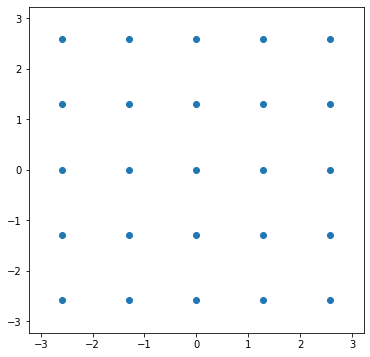

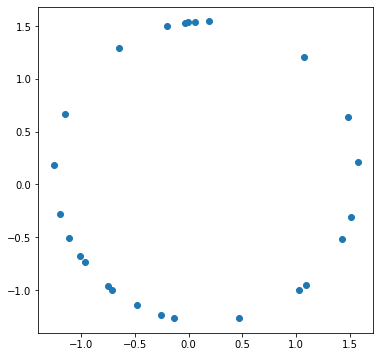

In [224]:
x,y,vx,vy = create_initial(N,box_size,temperature)
print(numba.typeof(x))
plt.figure(figsize=(6,6))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()
plt.figure(figsize=(6,6))
plt.scatter(vx,vy)
plt.show()

In [129]:
@njit
def verlet_list(x, y, box_size, r_v = 2.5):
    N = len(x)
    r2_v = r_v*r_v
    
    n_viz = np.zeros(N, dtype=np.int64)             # número de vizinhos por partícula
    viz = np.full(N*(N-1), -1, dtype=np.int64)      # os n_viz[i] vizinhos listados
    
    count = 0
    for i in range(N):                              # loop sobre todas as partículas
        for j in range(N):                          # loop sobre todos os possíveis vizinhos
            dist = distance(x[i], y[i], x[j], y[j], box_size)[0]
            dist2 = dist*dist
            if dist2 <= r2_v and dist != 0: 
                viz[count] = j
                count += 1
                n_viz[i] += 1
    
    viz_2 = np.empty(count, dtype=np.int64)
    for i in range(count):
        viz_2[i] = viz[i]
    
    return n_viz, viz_2

In [100]:
a,b = verlet_list(x,y,box_size,1)
print(a)
print(b)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 1  4  5 20  0  2  6 21  1  3  7 22  2  4  8 23  0  3  9 24  0  6  9 10
  1  5  7 11  2  6  8 12  3  7  9 13  4  5  8 14  5 11 14 15  6 10 12 16
  7 11 13 17  8 12 14 18  9 10 13 19 10 16 19 20 11 15 17 21 12 16 18 22
 13 17 19 23 14 15 18 24  0 15 21 24  1 16 20 22  2 17 21 23  3 18 22 24
  4 19 20 23]


In [367]:
@njit
def lennard_jones_energy(dist, r_c = 2.5):
    epsilon = 0.1
    sigma = 1
    
    if dist <= r_c:
        res = 4*epsilon*((np.power(sigma/dist,12) - np.power(sigma/dist,6)) - (np.power(sigma/r_c,12) - np.power(sigma/r_c,6)))  
    
    else:
        res = 0
        
    return res

In [368]:
@njit
def lennard_jones_force(dist, r_c = 2.5):
    epsilon = 0.1
    sigma = 1
    
    if dist <= r_c:
        res = (48*epsilon/(sigma*sigma)) * (np.power(sigma/dist,14) - 1/2 * np.power(sigma/dist,8))
        
    else:
        res = 0
        
    return res

In [103]:
@njit
def calculate_force(x, y, i, j, box_size, r_c = 2.5):
    # calcula a força que j faz em i
    N = len(x)
    
    force = np.zeros(2)
    
    dist, x_ij, y_ij = distance(x[i],y[i],x[j],y[j],box_size)
    
    force_mod = lennard_jones_force(dist,r_c)
    
    force[0] = force_mod * x_ij  
    force[1] = force_mod * y_ij
    
    return force

In [125]:
@njit
def calculate_energy(x, y, vx, vy, box_size, r_c = 2.5):
    N = len(x)
    energia = 0 
    
    for i in range(N):
        energia += 1/2 * (vx[i]*vx[i] + vy[i]*vy[i])
        for j in range(i+1,N):
            dist = distance(x[i],y[i],x[j],y[j],box_size)[0]
            energia += lennard_jones_energy(dist, r_c)
            
    return energia

In [195]:
@njit 
def calculate_forces(x,y,n_viz,viz,box_size):
    N = len(x)
    forces = np.zeros((N,2))

    for i in range(N):
        for j in range(int(sum(n_viz[:i])),int(sum(n_viz[:i+1]))):
            forces[i] += calculate_force(x,y,i,viz[j],box_size)
        
    return forces

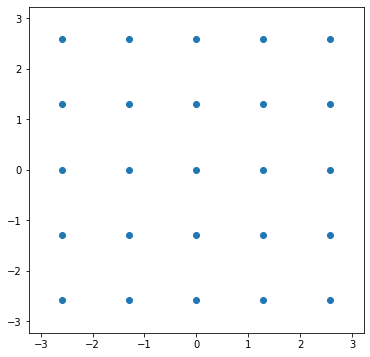

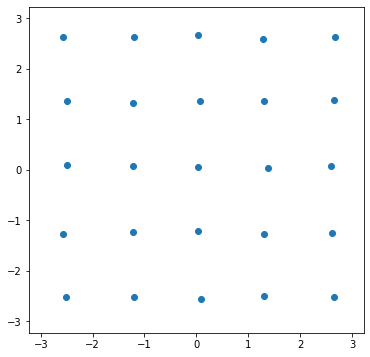

[[-0.26920438  0.24370658]
 [-0.21467074 -0.5661813 ]
 [ 0.55657404  0.5248694 ]
 [ 0.05815127  0.07279828]
 [-0.39369687 -0.27850846]
 [ 0.15207636  0.04319888]
 [ 0.40256543 -0.04626645]
 [ 0.08024029  0.18004207]
 [-0.08731311 -0.14639279]
 [ 0.49629218 -0.04034257]
 [-0.0112845  -0.1864721 ]
 [ 0.01186576  0.12546957]
 [-0.39569751 -0.08919595]
 [ 0.04568379  0.07725446]
 [ 0.13964864  0.04159404]
 [-0.39709341  0.41310537]
 [-0.10022014 -0.07043224]
 [ 0.06103418 -0.07107248]
 [-0.36762451  0.27562303]
 [-0.69812103 -0.47326558]
 [ 0.34176579  0.30289785]
 [ 0.09499001 -0.36491284]
 [-0.35913615  0.08155231]
 [ 0.25002894  0.22652079]
 [ 0.60314568 -0.27558986]]


In [197]:
x,y,vx,vy = create_initial(N,box_size,temperature)
plt.figure(figsize=(6,6))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()

for i in range(len(x)):
    x[i] += rd.random()*0.1
    y[i] += rd.random()*0.1
    
plt.figure(figsize=(6,6))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()

n_viz, viz = verlet_list(x, y, box_size)

#print(n_viz,viz)
print(calculate_forces(x,y,n_viz,viz,box_size))

In [191]:
n = 5
N = n*n                    # número de partículas

rho = 0.6                    # densidade de partículas
box_size = np.sqrt(N/rho)  # dimensão linear da caixa
temperature = 1.05

r_c = 2.5                  # raio de corte da interação de Lennard-Jones
r2_c = r_c*r_c

r_v = 2.5                   # raio da lista de Verlet
r2_v = r_v*r_v   
print(box_size)

6.454972243679029


In [235]:
@njit
def simulate(x, y, vx, vy, n_viz, viz, forces, box_sixe, passo, dt = 0.001, r_v = 2.5):
    N = len(x)
    energia = 0
    
    # calcula a lista de vizinhos (condição: à cada x passos (tem que mudar segundo a teoria))
    if passo%1 == 0:
        n_viz, viz = verlet_list(x, y, r_v, box_size)

    # calcula a força entre as partículas
    forces = calculate_forces(x,y,n_viz,viz,box_size)
            
    # evolui as posições e velocidades

    # evolui os valores das velocidades
    for i in range(N):
        vx[i] = vx[i] + 1/2 * forces[i][0]*dt
        vy[i] = vy[i] + 1/2 * forces[i][1]*dt
    # evolui os valores das posições
    for i in range(N):
        x[i] = x[i] + vx[i]*dt
        
        # move uma partícula para dentro da caixa caso ela saia (como em Pacman)
        if x[i] >= box_size/2:
            x[i] -= box_size
        elif x[i] < -box_size/2:
            x[i] += box_size
            
        y[i] = y[i] + vy[i]*dt
        
        # move uma partícula para dentro da caixa caso ela saia (como em Pacman)
        if y[i] >= box_size/2:
            y[i] -= box_size
        elif y[i] < -box_size/2:
            y[i] += box_size

    # calcula a força entre as partículas
    forces = calculate_forces(x,y,n_viz,viz,box_size)
    
    # evolui os valores das velocidades
    for i in range(N):
        vx[i] = vx[i] + 1/2 * forces[i][0]*dt
        vy[i] = vy[i] + 1/2 * forces[i][1]*dt
        
    energia += calculate_energy(x,y,vx,vy,box_size)
    
    return x, y, vx, vy, n_viz, viz, forces, energia

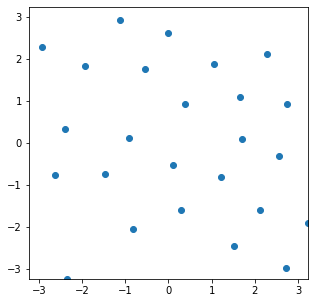

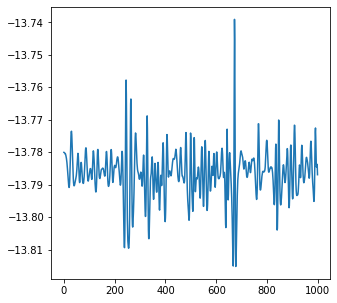

In [369]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

x,y,vx,vy = create_initial(N,box_size,temperature)

energias[0] = calculate_energy(x,y,vx,vy,box_size,r_c)

n_viz, viz = verlet_list(x, y, r_v, box_size)

forces = calculate_forces(x,y,n_viz,viz,box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    energias[i] = energia
    if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

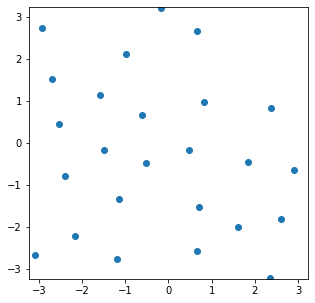

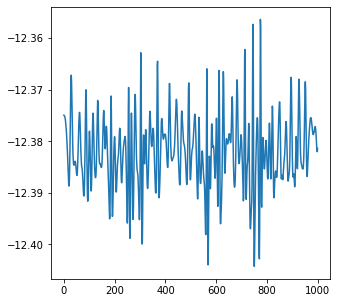

In [370]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

xs0 = np.zeros((passos,N))
ys0 = np.zeros((passos,N))

x,y,vx,vy = create_initial(N,box_size,temperature)

xs0[0] = x
ys0[0] = y

energias[0] = calculate_energy(x,y,vx,vy,box_size,r_c)

n_viz, viz = verlet_list(x, y, r_v, box_size)

forces = calculate_forces(x,y,n_viz,viz,box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    xs0[i] = x
    ys0[i] = y
    energias[i] = energia
    """if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

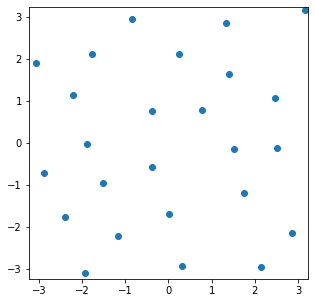

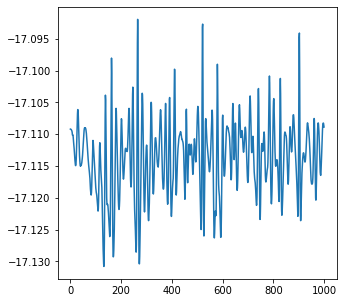

In [371]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

xs1 = np.zeros((passos,N))
ys1 = np.zeros((passos,N))

x,y,vx,vy = create_initial(N,box_size,temperature)

for i in range(N):
    x[i] += (rd.random() - 1/2) * 10e-3
    y[i] += (rd.random() - 1/2) * 10e-3

xs1[0] = x
ys1[0] = y

energias[0] = calculate_energy(x,y,vx,vy,box_size,r_c)

n_viz, viz = verlet_list(x, y, r_v, box_size)

forces = calculate_forces(x,y,n_viz,viz,box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    xs1[i] = x
    ys1[i] = y
    energias[i] = energia
    """if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

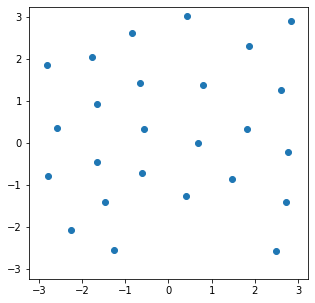

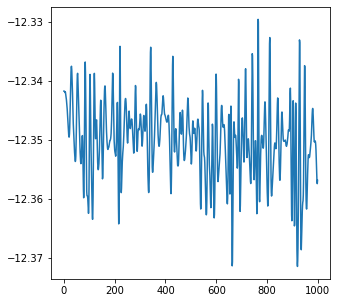

In [372]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

xs2 = np.zeros((passos,N))
ys2 = np.zeros((passos,N))

x,y,vx,vy = create_initial(N,box_size,temperature)

for i in range(N):
    x[i] += (rd.random() - 1/2) * 10e-6
    y[i] += (rd.random() - 1/2) * 10e-6

xs2[0] = x
ys2[0] = y

energias[0] = calculate_energy(x,y,vx,vy,box_size,r_c)

n_viz, viz = verlet_list(x, y, r_v, box_size)

forces = calculate_forces(x,y,n_viz,viz,box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    xs2[i] = x
    ys2[i] = y
    energias[i] = energia
    """if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

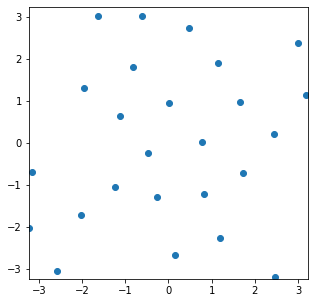

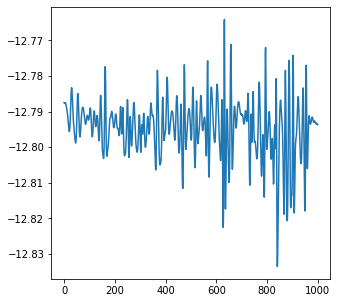

In [373]:
passos = 1000
dt = 0.005
energias = np.zeros(passos)
forces = np.zeros((N,2))

xs3 = np.zeros((passos,N))
ys3 = np.zeros((passos,N))

x,y,vx,vy = create_initial(N,box_size,temperature)

for i in range(N):
    x[i] += (rd.random() - 1/2) * 10e-3
    y[i] += (rd.random() - 1/2) * 10e-3

xs3[0] = x
ys3[0] = y

energias[0] = calculate_energy(x,y,vx,vy,box_size,r_c)

n_viz, viz = verlet_list(x, y, r_v, box_size)

forces = calculate_forces(x,y,n_viz,viz,box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    xs3[i] = x
    ys3[i] = y
    energias[i] = energia
    """if i%10== 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias)
plt.show()

In [374]:
delta_r2_1 = np.zeros(passos) 
delta_r2_2 = np.zeros(passos)
delta_r2_3 = np.zeros(passos) 
aux1=0
aux2=0
aux3=0

for i in range(passos):
    for j in range(N):
        aux1 += (xs1[i][j] - xs0[i][j]) * (xs1[i][j] - xs0[i][j]) + (ys1[i][j] - ys0[i][j]) * (ys1[i][j] - ys0[i][j])
        aux2 += (xs2[i][j] - xs0[i][j]) * (xs2[i][j] - xs0[i][j]) + (ys2[i][j] - ys0[i][j]) * (ys2[i][j] - ys0[i][j])
        aux3 += (xs3[i][j] - xs0[i][j]) * (xs3[i][j] - xs0[i][j]) + (ys3[i][j] - ys0[i][j]) * (ys3[i][j] - ys0[i][j])
    aux1 = aux1/N
    aux2 = aux2/N
    aux3 = aux3/N
    delta_r2_1[i] = aux1
    delta_r2_2[i] = aux2
    delta_r2_3[i] = aux3

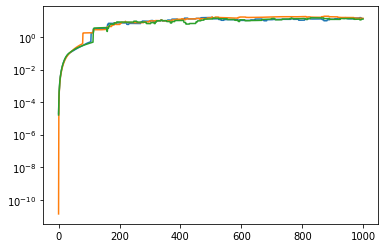

In [375]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.plot(delta_r2_1)
ax.plot(delta_r2_2)
ax.plot(delta_r2_3)

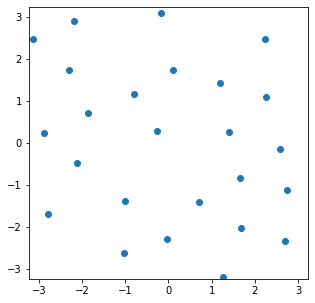

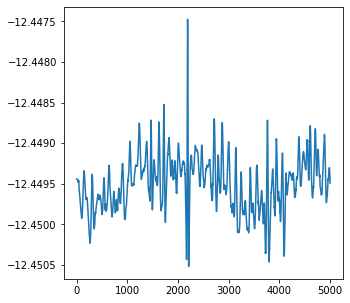

In [406]:
t = 5
dt = 10e-4
passos = int(t/dt)
energias_4 = np.zeros(passos)
forces = np.zeros((N,2))

x,y,vx,vy = create_initial(N,box_size,temperature)

energias_4[0] = calculate_energy(x,y,vx,vy,box_size,r_c)

n_viz, viz = verlet_list(x, y, r_v, box_size)

forces = calculate_forces(x,y,n_viz,viz,box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    energias_4[i] = energia
    """if i%100 == 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias_4)
plt.show()

In [415]:
media_energia = sum(energias_4)/passos

desvio = 0

for i in range(passos):
    desvio += (energias_4[i]-media_energia)*(energias_4[i]-media_energia)
    
desvio = desvio/(passos-1)
desvio = np.sqrt(desvio)
print(media_energia, desvio)

-12.44949459353404 0.00033559335349817195


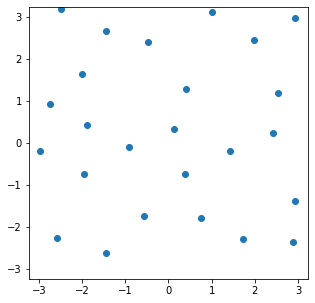

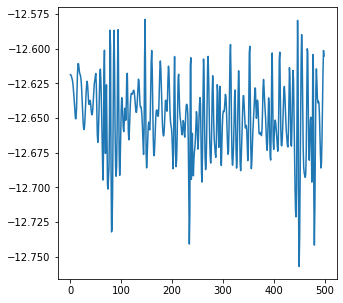

In [417]:
t = 5
dt = 10e-3
passos = int(t/dt)
energias_3 = np.zeros(passos)
forces = np.zeros((N,2))

x,y,vx,vy = create_initial(N,box_size,temperature)

energias_3[0] = calculate_energy(x,y,vx,vy,box_size,r_c)

n_viz, viz = verlet_list(x, y, r_v, box_size)

forces = calculate_forces(x,y,n_viz,viz,box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    energias_3[i] = energia
    if i%100 == 0:
        """plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)"""

plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias_3)
plt.show()

In [419]:
media_energia = sum(energias_3)/passos

desvio = 0

for i in range(passos):
    desvio += (energias_3[i]-media_energia)*(energias_3[i]-media_energia)
    
desvio = desvio/(passos-1)
desvio = np.sqrt(desvio)
print(media_energia, desvio)

-12.650110518898288 0.02693893963357094


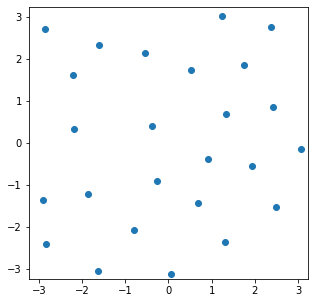

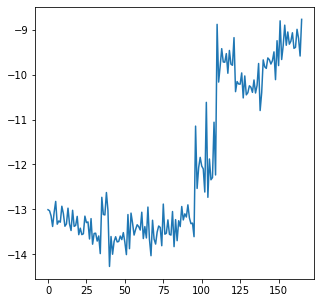

In [420]:
t = 5
dt = 3*10e-3
passos = int(t/dt)
energias_2 = np.zeros(passos)
forces = np.zeros((N,2))

x,y,vx,vy = create_initial(N,box_size,temperature)

energias_2[0] = calculate_energy(x,y,vx,vy,box_size,r_c)

n_viz, viz = verlet_list(x, y, r_v, box_size)

forces = calculate_forces(x,y,n_viz,viz,box_size)

for i in range(1,passos):
    x, y, vx, vy, n_viz, viz, forces, energia = simulate(x,y,vx, vy,n_viz, viz, forces, box_size, i, dt)
    energias_2[i] = energia
    if i%10 == 0:
        plt.figure(figsize=(5,5))
        plt.xlim(-box_size/2,box_size/2)
        plt.ylim(-box_size/2,box_size/2)
        plt.scatter(x,y)
        plt.show()
        display.clear_output(wait=True)
        
plt.figure(figsize=(5,5))
plt.xlim(-box_size/2,box_size/2)
plt.ylim(-box_size/2,box_size/2)
plt.scatter(x,y)
plt.show()        
plt.figure(figsize=(5,5))
plt.plot(energias_2)
plt.show()

In [421]:
media_energia = sum(energias_2)/passos

desvio = 0

for i in range(passos):
    desvio += (energias_2[i]-media_energia)*(energias_2[i]-media_energia)
    
desvio = desvio/(passos-1)
desvio = np.sqrt(desvio)
print(media_energia, desvio)

-12.037150562595844 1.7381398435621487
